<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import os
import numpy as np
import pandas as pd
from einops import rearrange,reduce,repeat
from einops.layers.torch import EinMix as Mix
from einops.layers.torch import Rearrange,Reduce
import random

def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


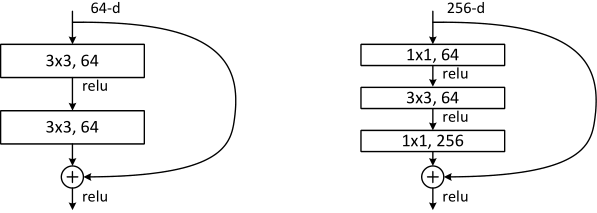

In [38]:
class ResidualBlock(nn.Module):
  def __init__(self,input_channel,bottleneck_channel,output_channel,down_sample=False):
    super(ResidualBlock,self).__init__()
    if down_sample==True:
      conv_stride =2
      self.residual = nn.Sequential(
          nn.Conv2d(input_channel,output_channel,(1,1),stride=conv_stride,bias=False),
          nn.BatchNorm2d(output_channel),
      )
    else:
      conv_stride =1
      self.residual = nn.Identity()

    self.bottle_neck = nn.Sequential(
        nn.Conv2d(input_channel,bottleneck_channel,(1,1),bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(bottleneck_channel,bottleneck_channel,(3,3),stride=conv_stride ,padding=1,bias=False),
        nn.BatchNorm2d(bottleneck_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(bottleneck_channel,output_channel,(1,1),bias=False),
        nn.BatchNorm2d(output_channel),

    )
    
  def forward(self,x):
    x = F.relu(self.bottle_neck(x) + self.residual(x),inplace=True)
    return x

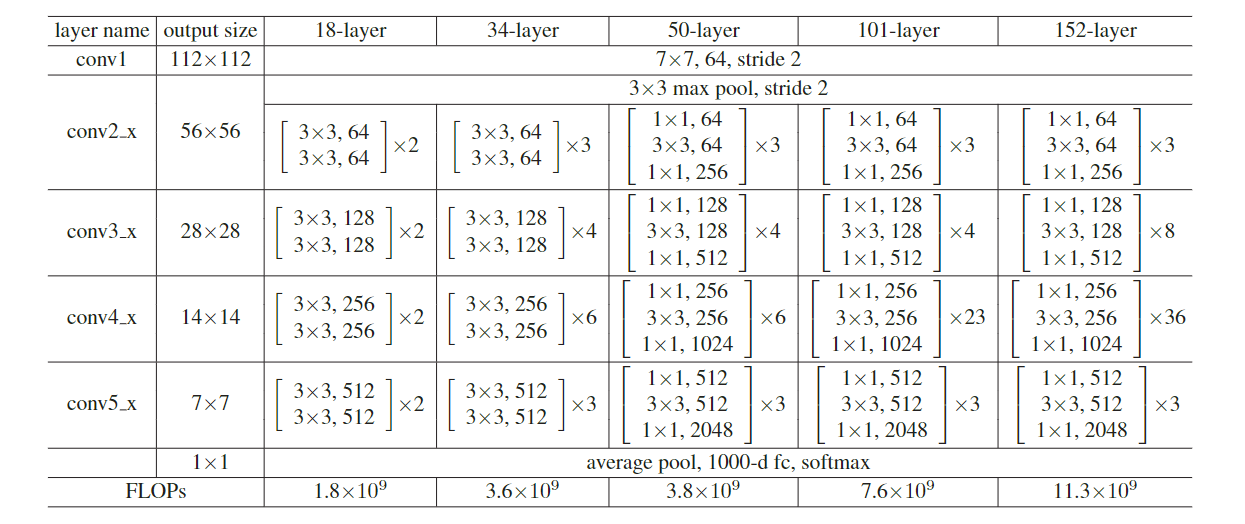

In [43]:
class Resnet50(nn.Module):
  def __init__(self,num_class,inpue_channel):
    super(Resnet50,self).__init__()
    channel_list = [64,64,256,128,512,256,1024,512,2048]
    repeat=[3,4,6,3]
    self.begin = nn.Sequential(
        nn.Conv2d(inpue_channel,channel_list[0],(7,7),stride=2,padding=3,bias=False),
        nn.BatchNorm2d(channel_list[0]),
        nn.ReLU(inplace=True),
        nn.MaxPool2d((3,3),stride=2,padding=1)
    )
    self.conv2_x = nn.Sequential(
        ResidualBlock(channel_list[0],channel_list[1],channel_list[2],True),
        *[ResidualBlock(channel_list[2],channel_list[1],channel_list[2],False) for i in range(repeat[0]-1)]
    )
    self.conv3_x = nn.Sequential(
        ResidualBlock(channel_list[2],channel_list[3],channel_list[4],True),
        *[ResidualBlock(channel_list[4],channel_list[3],channel_list[4],False) for i in range(repeat[1]-1)]
    )
    self.conv4_x = nn.Sequential(
        ResidualBlock(channel_list[4],channel_list[5],channel_list[6],True),
        *[ResidualBlock(channel_list[6],channel_list[5],channel_list[6],False) for i in range(repeat[2]-1)]
    )
    self.conv5_x = nn.Sequential(
        ResidualBlock(channel_list[6],channel_list[7],channel_list[8],True),
        *[ResidualBlock(channel_list[8],channel_list[7],channel_list[8],False) for i in range(repeat[3]-1)]
    )
    self.final = nn.Sequential(
        Reduce('b c h w ->b c','mean'),
        nn.Linear(channel_list[-1],num_class)
    )
  def forward(self,x):
    x = self.begin(x)
    x = self.conv2_x(x)
    x = self.conv3_x(x)
    x = self.conv4_x(x)
    x = self.conv5_x(x)
    x = self.final(x)
    return x


In [44]:
model =Resnet50(1000,3)
x=torch.randn(3,3,224,224)
model(x).shape

torch.Size([3, 1000])

In [ ]:
import torchvision
resnet50 = torchvision.models.resnet50()
#resnet50

In [47]:
total_param_ours = []
for name,param in model.named_parameters():
  total_param_ours+=[np.prod(param.size())]
print(f"我们的模型总参数量为:{sum(total_param_ours)}")

total_param_official = []
for name,param in resnet50.named_parameters():
  total_param_official+=[np.prod(param.size())]
print(f"pytorch官方的模型总参数量为:{sum(total_param_official)}")
print(f"参数个数{len(total_param_ours)},{len(total_param_official)}")


我们的模型总参数量为:25557032
pytorch官方的模型总参数量为:25557032
参数个数161,161
